In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Projects/ai_for_medicine


In [ ]:
# !unzip Data/pneumonia_classification/Processed.zip -d Data/pneumonia_classification/


In [ ]:
import os
print("val 0:",len(os.listdir("Data/pneumonia_classification/Processed/val/0")),
      "val 1:",len(os.listdir("Data/pneumonia_classification/Processed/val/1")),
      "train 0:",len(os.listdir("Data/pneumonia_classification/Processed/train/0")),
      "train 1:",len(os.listdir("Data/pneumonia_classification/Processed/train/1"))
)

val 0: 2079 val 1: 605 train 0: 18595 train 1: 5407


In [ ]:
import torch
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/train", loader = load_file, extensions="npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/val", loader = load_file, extensions="npy", transform = val_transforms)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


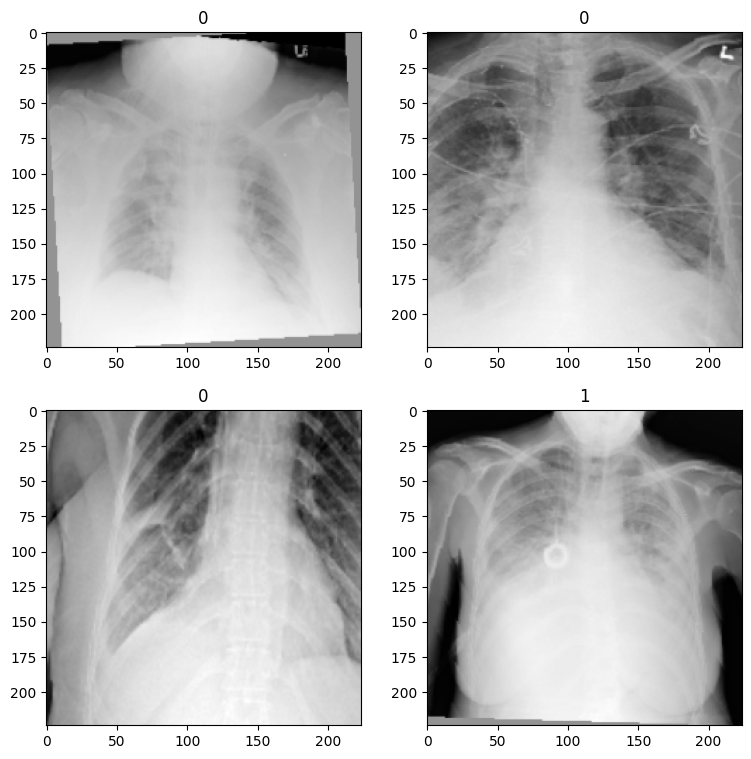

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
  for j in range(2):
    random_ind = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_ind]
    print(x_ray.shape)
    axis[i][j].imshow(x_ray[0], cmap="gray")
    axis[i][j].set_title(label)

In [ ]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaModel(torch.nn.Module):
  def __init__(self):
    super(PneumoniaModel, self).__init__()
    self.model = torchvision.models.resnet34(pretrained=True)

    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)


  def forward(self, x):
    return self.model(x)


In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
model = PneumoniaModel().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


In [ ]:
def calculate_accuracy(outputs, labels):
    # Convert outputs to predictions: 1 if output >= 0.5, 0 otherwise
    preds = outputs >= 0.5
    correct = (preds == labels.byte()).float()  # Convert to float for division
    accuracy = correct.sum() / len(correct)
    return accuracy

In [ ]:
for epoch in range(25):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs.squeeze(), labels.float())  # Adjust the output shape if necessary
        accuracy = calculate_accuracy(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    scheduler.step()


    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs.squeeze(), labels.float())
            accuracy = calculate_accuracy(outputs.squeeze(), labels)

            val_running_loss += loss.item()
            val_running_accuracy += accuracy.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

print('Finished Training')


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.7446, Train Acc: 0.7975, Val Loss: 0.6478, Val Acc: 0.8408


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.6873, Train Acc: 0.8136, Val Loss: 0.6942, Val Acc: 0.8425


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.6764, Train Acc: 0.8110, Val Loss: 0.6830, Val Acc: 0.8427


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.6487, Train Acc: 0.8202, Val Loss: 0.6536, Val Acc: 0.8221


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.6404, Train Acc: 0.8229, Val Loss: 0.6012, Val Acc: 0.8298


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.6083, Train Acc: 0.8335, Val Loss: 0.6050, Val Acc: 0.8391


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.6051, Train Acc: 0.8317, Val Loss: 0.6367, Val Acc: 0.8438


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.5875, Train Acc: 0.8381, Val Loss: 0.6474, Val Acc: 0.8234


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.5729, Train Acc: 0.8442, Val Loss: 0.6432, Val Acc: 0.8383


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.5501, Train Acc: 0.8488, Val Loss: 0.6403, Val Acc: 0.8367


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.5110, Train Acc: 0.8593, Val Loss: 0.6734, Val Acc: 0.8286


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.4951, Train Acc: 0.8637, Val Loss: 0.6638, Val Acc: 0.8324


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.4690, Train Acc: 0.8728, Val Loss: 0.7452, Val Acc: 0.8431


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.4483, Train Acc: 0.8773, Val Loss: 0.7705, Val Acc: 0.8357


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.4396, Train Acc: 0.8842, Val Loss: 0.7170, Val Acc: 0.8078


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.3934, Train Acc: 0.8941, Val Loss: 0.8321, Val Acc: 0.8256


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.3529, Train Acc: 0.9070, Val Loss: 0.8560, Val Acc: 0.8172


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.3285, Train Acc: 0.9143, Val Loss: 0.9857, Val Acc: 0.8137


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.3102, Train Acc: 0.9166, Val Loss: 0.9601, Val Acc: 0.8350


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.2929, Train Acc: 0.9249, Val Loss: 0.9458, Val Acc: 0.8227


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.2587, Train Acc: 0.9341, Val Loss: 1.2107, Val Acc: 0.8139


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.2477, Train Acc: 0.9356, Val Loss: 1.1840, Val Acc: 0.8233


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.2376, Train Acc: 0.9390, Val Loss: 1.0728, Val Acc: 0.8233


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.2095, Train Acc: 0.9476, Val Loss: 1.2753, Val Acc: 0.8110


  0%|          | 0/376 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.1940, Train Acc: 0.9518, Val Loss: 1.3928, Val Acc: 0.8226
Finished Training


In [ ]:
model_save_path = 'models/pneumonia_classification_RESNET34.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
model.load_state_dict(torch.load('models/pneumonia_classification_RESNET34.pth'))

<All keys matched successfully>

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for efficiency
with torch.no_grad():
    for inputs, labels in val_loader:
        # Assuming your model and data are on the same device (CPU or CUDA)
        # Move inputs to the same device as your model if necessary
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert outputs to probabilities and get the predicted class
        preds_bool = outputs >= 0.5


        predictions = preds_bool.int()
        # preds

        # Collect the predictions and true labels
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

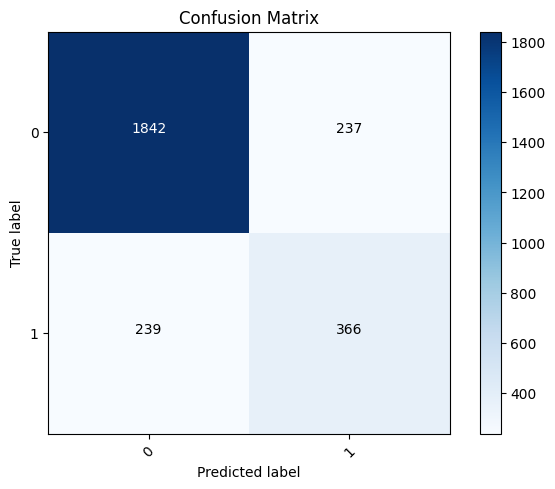

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Assuming a list of class names in the variable 'class_names'
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1], title='Confusion Matrix')

plt.show()

In [ ]:
def calculate_metrics(cm):
    # Accuracy
    accuracy = np.trace(cm) / np.sum(cm).astype('float')

    # Precision per class
    precision = np.diag(cm) / np.sum(cm, axis=0).astype('float')

    # Recall per class
    recall = np.diag(cm) / np.sum(cm, axis=1).astype('float')

    # Mean Precision and Recall
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (per class): {precision}")
    print(f"Recall (per class): {recall}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")

In [ ]:
calculate_metrics(cm)

Accuracy: 0.8227
Precision (per class): [0.88515137 0.60696517]
Recall (per class): [0.88600289 0.60495868]
Mean Precision: 0.7461
Mean Recall: 0.7455


In [ ]:
cm

array([[1842,  237],
       [ 239,  366]])

In [ ]:
class PneumoniaModel(torch.nn.Module):
  def __init__(self):
    super(PneumoniaModel, self).__init__()
    self.model = torchvision.models.resnet18()

    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])


  def forward(self, x):
    feature_map = self.feature_map(x)
    pred = self.model(x)

    return pred, feature_map

In [ ]:
model = PneumoniaModel()

In [ ]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()


    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [ ]:
def cam(model, img):
    """
    Compute class activation map according to cam algorithm
    """
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # We reshape the 512x7x7 feature tensor into a 512x49 tensor in order to simplify the multiplication
    features = features.reshape((c, h*w))

    # Get only the weights, not the bias
    weight_params = list(model.model.fc.parameters())[0]

    # Remove gradient information from weight parameters to enable numpy conversion
    weight = weight_params[0].detach()
    print(weight.shape)
    # Compute multiplication between weight and features with the formula from above.
    # We use matmul because it directly multiplies each filter with the weights
    # and then computes the sum. This yields a vector of 49 (7x7 elements)
    cam = torch.matmul(weight, features)
    print(features.shape)

    ### The following loop performs the same operations in a less optimized way
    #cam = torch.zeros((7 * 7))
    #for i in range(len(cam)):
    #    cam[i] = torch.sum(weight*features[:,i])
    ##################################################################

    # Normalize and standardize the class activation map (Not always necessary, thus not shown in the lecture)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()

    print(cam_img, torch.sigmoid(pred))

    return cam_img, torch.sigmoid(pred)



In [ ]:
def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]

    # Create a figure
    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [ ]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [ ]:
img = val_dataset[-6][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([512])
torch.Size([512, 49])
tensor([[0.1098, 0.5251, 1.0000, 0.6118, 0.5632, 0.3644, 0.8517],
        [0.0626, 0.7886, 0.4132, 0.4802, 0.5866, 0.0472, 0.5618],
        [0.0000, 0.3555, 0.3824, 0.3635, 0.5996, 0.6250, 0.4734],
        [0.2985, 0.2713, 0.3846, 0.4141, 0.5765, 0.5178, 0.3994],
        [0.4508, 0.3148, 0.7038, 0.3738, 0.6269, 0.6411, 0.7819],
        [0.6359, 0.4893, 0.5379, 0.5448, 0.4765, 0.7209, 0.7836],
        [0.3341, 0.3293, 0.2694, 0.3396, 0.4454, 0.5300, 0.7587]]) tensor([[0.4799]])


In [ ]:
img.unsqueeze(0).shape

torch.Size([1, 1, 224, 224])

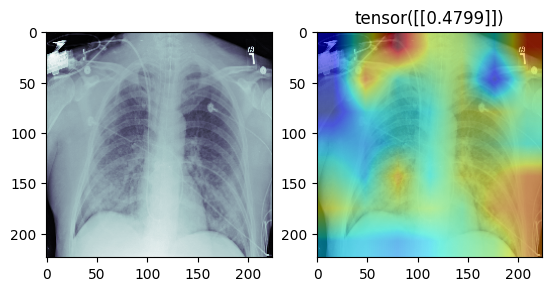

In [ ]:
visualize(img, activation_map, pred)  # Visualize CAM